# Binary classification
---------------------------------

Download the Australian weather dataset from [https://www.kaggle.com/jsphyg/weather-dataset-rattle-package](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package).
 This dataset tries to predict whether or not it will rain tomorrow by
 training a classification model on target `RainTomorrow`.

### Load the data

In [1]:
# Import packages
import numpy as np
import pandas as pd
from sklearn.metrics import fbeta_score
from atom import ATOMClassifier

# Load the Australian weather dataset
X = pd.read_csv('../weatherAUS.csv')
X = X.drop(['RISK_MM', 'Date'], axis=1)  # Drop unrelated features

### Run the pipeline

In [11]:
# Call ATOM using only a percentage of the complete dataset (for explanatory purposes)
atom = ATOMClassifier(X, y="RainTomorrow", percentage=5, log='auto', n_jobs=2, verbose=3)

<<=============== ATOM ===============>>
Parallel processing with 2 cores.
Initial data cleaning...
 --> Dropping 45 duplicate rows.
Algorithm task: binary classification.

Dataset stats ===================>
Shape: (7107, 22)
Missing values: 15680
Categorical columns: 5
Scaled: False
----------------------------------
Size of training set: 4974
Size of test set: 2133
----------------------------------
Class balance: No:Yes <==> 3.4:1.0
Instances in RainTomorrow per class:
|        |    total |    train_set |    test_set |
|:-------|---------:|-------------:|------------:|
| 0: No  |     5502 |         3854 |        1648 |
| 1: Yes |     1605 |         1120 |         485 |



In [12]:
# If we change a column during the pre-processing,
# we need to call the update method to update all data attributes

atom.X['MaxTemp'] = np.log(atom.X['MaxTemp'])

# MaxTemp has now been changed for atom.X, but not in atom.X_train, atom.dataset, etc...
# To do so, we use the update method...
atom.update('X')

assert atom.X['MaxTemp'].equals(atom.dataset['MaxTemp'])

In [13]:
# Impute missing values
atom.impute(strat_num='knn', strat_cat='remove', max_frac_rows=0.8)

Imputing missing values...
 --> Removing 741 rows for containing too many missing values.
 --> Imputing 3 missing values using the KNN imputer in feature MinTemp.
 --> Imputing 4 missing values using the KNN imputer in feature MaxTemp.
 --> Imputing 43 missing values using the KNN imputer in feature Rainfall.
 --> Imputing 2315 missing values using the KNN imputer in feature Evaporation.
 --> Imputing 2661 missing values using the KNN imputer in feature Sunshine.
 --> Removing 222 rows due to missing values in feature WindGustDir.
 --> Imputing 221 missing values using the KNN imputer in feature WindGustSpeed.
 --> Removing 327 rows due to missing values in feature WindDir9am.
 --> Removing 24 rows due to missing values in feature WindDir3pm.
 --> Imputing 6 missing values using the KNN imputer in feature WindSpeed9am.
 --> Imputing 2 missing values using the KNN imputer in feature WindSpeed3pm.
 --> Imputing 25 missing values using the KNN imputer in feature Humidity9am.
 --> Imputing

In [14]:
# Encode the categorical features
atom.encode(max_onehot=10, frac_to_other=0.04)

Encoding categorical features...
 --> Target-encoding feature Location.  Contains 1 unique categories.
 --> Target-encoding feature WindGustDir.  Contains 16 unique categories.
 --> Target-encoding feature WindDir9am.  Contains 16 unique categories.
 --> Target-encoding feature WindDir3pm.  Contains 16 unique categories.
 --> Label-encoding feature RainToday. Contains 2 unique categories.


In [15]:
# Perform undersampling of the majority class to balance the dataset
atom.balance(undersample=0.8)

Performing undersampling...
 --> Removing 249 rows from class No.


In [16]:
# Remove outliers from the training set
atom.outliers(max_sigma=5)

Handling outliers...
 --> Dropping 18 rows due to outliers.


In [17]:
# Select only the best 10 features
atom.feature_selection(strategy="univariate", max_features=15, max_correlation=0.8)

# See which features were removed due to collinearity
atom.collinear

Performing feature selection...
 --> Feature Location was removed due to low variance: 0.00.
 --> Feature Pressure3pm was removed due to collinearity with another feature.
 --> Feature Temp9am was removed due to collinearity with another feature.
 --> Feature Temp3pm was removed due to collinearity with another feature.
 --> Feature MinTemp was removed after the univariate test (score: 9.36  p-value: 0.00).
 --> Feature Evaporation was removed after the univariate test (score: 27.00  p-value: 0.00).


,drop_feature,correlated_feature,correlation_value
0,Pressure3pm,Pressure9am,0.95413
1,Temp9am,"MinTemp, MaxTemp","0.9201, 0.89643"
2,Temp3pm,"MaxTemp, Temp9am","0.9587, 0.87527"


In [18]:
# Change the verbosity of ATOM to not print too much details while fitting
atom.verbose = 2

# Let's use a custom metric
def f2_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

# Let's compare the performance of various gradient boosting algorithms
atom.pipeline(['gbm', 'lgb', 'catb'],
              metric=f2_score,
              max_iter=5,
              init_points=5,
              cv=1,
              bagging=5)


Running pipeline =================>
Models in pipeline: GBM, LGB, CatB
Metric: f2_score


Running BO for Gradient Boosting Machine...
Final results for Gradient Boosting Machine:         
Bayesian Optimization ---------------------------
Best hyperparameters: {'n_estimators': 414, 'learning_rate': 1.0, 'subsample': 0.5, 'max_depth': 2, 'max_features': 0.8, 'criterion': 'mse', 'min_samples_split': 12, 'min_samples_leaf': 1, 'ccp_alpha': 0.0}
Best score on the BO: 0.7485
Time elapsed: 37.958s
Fitting -----------------------------------------
Score on the training set: 0.8465
Score on the test set: 0.5824
Time elapsed: 0.796s
Bagging -----------------------------------------
Mean: 0.5587   Std: 0.0105
Time elapsed: 3.562s
-------------------------------------------------
Total time: 42.316s


Running BO for LightGBM...
Final results for LightGBM:         
Bayesian Optimization ---------------------------
Best hyperparameters: {'n_estimators': 345, 'learning_rate': 0.6, 'max_depth': 3, 'n

### Analyze the results

In [19]:
# Let's have a look at the best model
print('And the winner is...', atom.winner.longname)

print('Score on the training set: ', atom.winner.score_train)
print('Score on the test set: ', atom.winner.score_test)

And the winner is... CatBoost
Score on the training set:  0.9390495867768595
Score on the test set:  0.6364787840405319


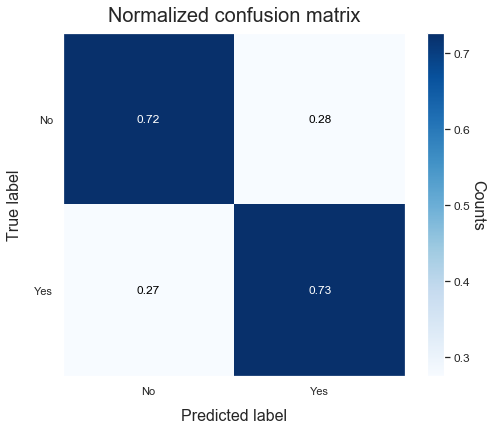

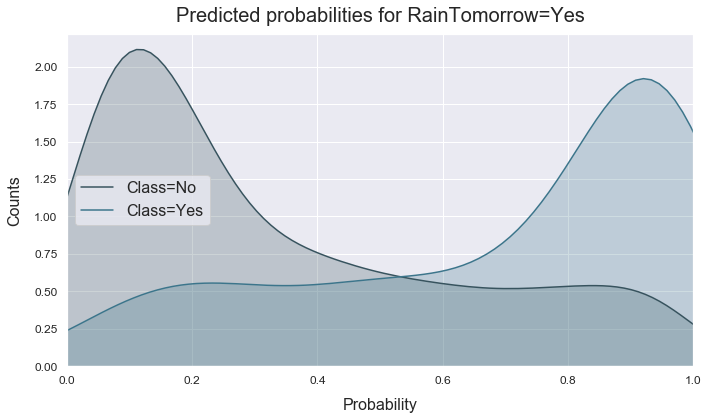

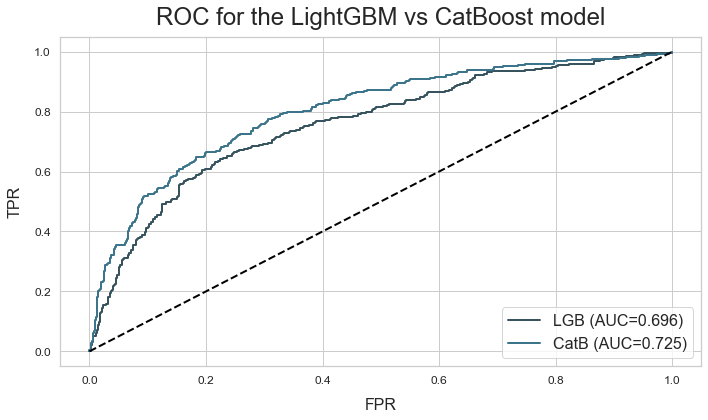

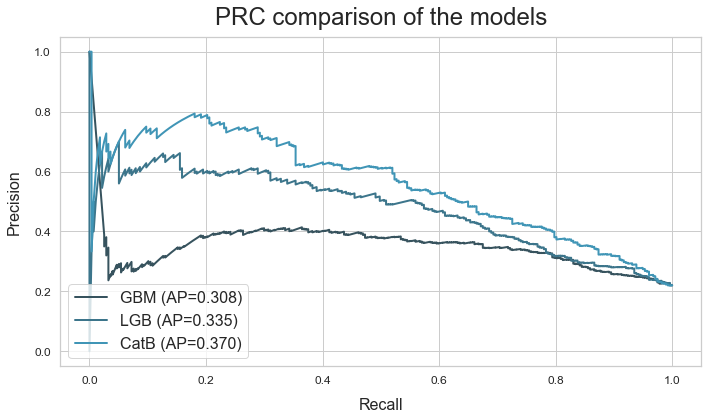

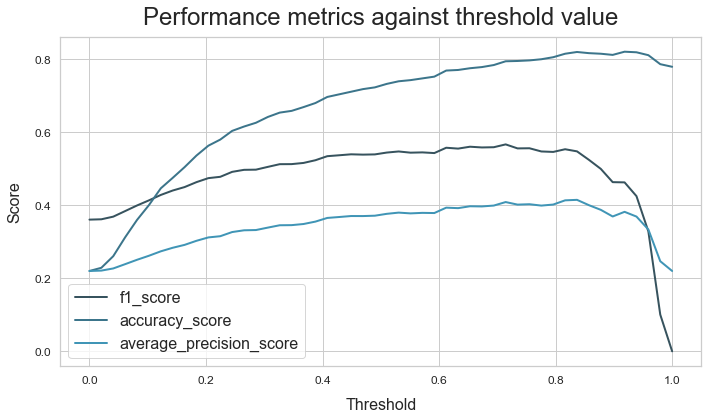

In [20]:
# Make some plots to analyze the results
atom.winner.plot_confusion_matrix(normalize=True, figsize=(7, 7), filename='confusion_matrix.png')
atom.winner.plot_probabilities()

# Change plots aesthetics
ATOMClassifier.set_style('whitegrid')
ATOMClassifier.set_title_fontsize(24)

atom.plot_ROC(models=('LGB', 'CatB'), title="ROC for the LightGBM vs CatBoost model")
atom.plot_PRC(title="PRC comparison of the models")
atom.catb.plot_threshold(metric=['f1', 'accuracy', 'average_precision'], steps=50, filename='thresholds.png')